<a href="https://colab.research.google.com/github/yashshroff99/College-Projects/blob/main/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

content_img = files.upload()

In [ ]:
import os

CONTENT_IMAGE_FN = list(content_img)[0]
CONTENT_IMAGE_FN_temp = CONTENT_IMAGE_FN.strip().replace(" ", "_")

if CONTENT_IMAGE_FN != CONTENT_IMAGE_FN_temp:
  os.rename(CONTENT_IMAGE_FN, CONTENT_IMAGE_FN_temp)
  CONTENT_IMAGE_FN = CONTENT_IMAGE_FN_temp

print("Content image filename :", CONTENT_IMAGE_FN)

Content image filename : content.jpeg


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
img = plt.imread(CONTENT_IMAGE_FN)
plt.axis('off')
plt.title('Content image')
plt.imshow(img)

In [ ]:
style_img = files.upload()

In [ ]:
STYLE_IMAGE_FN = list(style_img)[0]
STYLE_IMAGE_FN_temp = STYLE_IMAGE_FN.strip().replace(" ", "_")

if STYLE_IMAGE_FN != STYLE_IMAGE_FN_temp:
  os.rename(STYLE_IMAGE_FN, STYLE_IMAGE_FN_temp)

  STYLE_IMAGE_FN = STYLE_IMAGE_FN_temp

print("Style image filename :", STYLE_IMAGE_FN)

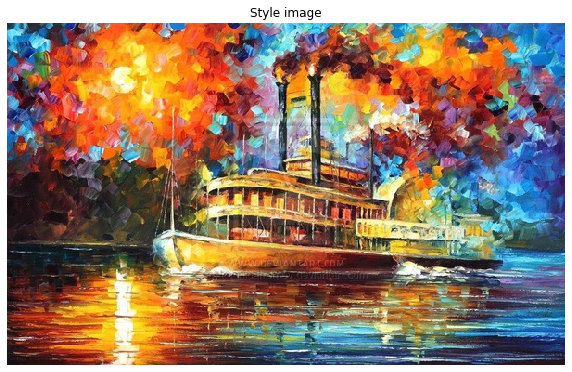

In [ ]:
fig = plt.figure(figsize=(10, 10))
img = plt.imread(STYLE_IMAGE_FN)
plt.axis('off')
plt.title('Style image')
plt.imshow(img)

In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp "/content/drive/My Drive/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5.zip" -t"/content"

In [ ]:
!ls

content.jpg  sample_data  vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5.zip
drive	     style.jpg


In [ ]:
!unzip /content/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5.zip

Archive:  /content/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5.zip
replace vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
from keras.applications.vgg19 import VGG19

weights     = "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"
vgg19_model = VGG19(weights=weights, include_top=False)

In [ ]:
# path where the content and style images are located
content_path = 'content.jepg'
style_path   = 'style.jpeg'

# Save the result as
save_name = 'generated.jpg'

# Vgg weights path
vgg_weights = "vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing import image as kp_image

#Keras is only used to load VGG19 model as a high level API to TensorFlow
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras import backend as K

#pillow is used for loading and saving images
from PIL import Image

#numPy is used for manipulation of array of object i.e Image in our case
import numpy as np


#list of layers to be considered for calculation of Content and Style Loss
content_layers = ['block3_conv3']
style_layers   = ['block1_conv1','block2_conv2','block4_conv3']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

#path where the content and style images are located
content_path = '/content/content.jpg'
style_path   = '/content/style.jpg'

#Save the result as
save_name = 'generated.jpg'

#path to where Vgg19 model weight is located
vgg_weights = "/content/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5"


def load_img(path_to_img):

  max_dim  = 512
  img      = Image.open(path_to_img)
  img_size = max(img.size)
  scale    = max_dim/img_size
  img      = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)

  img      = kp_image.img_to_array(img)

#We need to broadcast the image array such that it has a batch dimension
  img = np.expand_dims(img, axis=0)

#preprocess raw images to make it suitable to be used by VGG19 model
  out = tf.keras.applications.vgg19.preprocess_input(img)

  return tf.convert_to_tensor(out)

def deprocess_img(processed_img):
  x = processed_img.copy()

  #perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68

  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')

  return x


#Content Loss Function
def get_content_loss(content, target):
  return tf.reduce_mean(tf.square(content - target)) /2

#Style Loss Fucntion
def gram_matrix(input_tensor):

  #if input tensor is a 3D array of size Nh x Nw X Nc
  #we reshape it to a 2D array of Nc x (Nh*Nw)
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]

  #get gram matrix
  gram = tf.matmul(a, a, transpose_a=True)

  return gram

def get_style_loss(base_style, gram_target):

  height, width, channels = base_style.get_shape().as_list()
  gram_style = gram_matrix(base_style)

  #Original eqn as a constant to divide i.e 1/(4. * (channels ** 2) * (width * height) ** 2)
  return tf.reduce_mean(tf.square(gram_style - gram_target)) / (channels**2 * width * height) #(4.0 * (channels ** 2) * (width * height) ** 2)



#Use to pass content and style image through it
def get_feature_representations(model, content_path, style_path, num_content_layers):

  #Load our images in
  content_image = load_img(content_path)
  style_image   = load_img(style_path)

  #batch compute content and style features
  content_outputs = model(content_image)
  style_outputs   = model(style_image)

  #Get the style and content feature representations from our model
  style_features   = [ style_layer[0]  for style_layer    in style_outputs[num_content_layers:] ]
  content_features = [ content_layer[0] for content_layer in content_outputs[:num_content_layers] ]

  return style_features, content_features


#Total Loss
def compute_loss(model, loss_weights, generated_output_activations, gram_style_features, content_features, num_content_layers, num_style_layers):

  generated_content_activations = generated_output_activations[:num_content_layers]
  generated_style_activations   = generated_output_activations[num_content_layers:]

  style_weight, content_weight = loss_weights

  style_score = 0
  content_score = 0

  #Accumulate style losses from all layers
  #Here, we equally weight each contribution of each loss layer
  weight_per_style_layer = 1.0 / float(num_style_layers)
  for target_style, comb_style in zip(gram_style_features, generated_style_activations):
    temp = get_style_loss(comb_style[0], target_style)
    style_score += weight_per_style_layer * temp

  #Accumulate content losses from all layers
  weight_per_content_layer = 1.0 / float(num_content_layers)
  for target_content, comb_content in zip(content_features, generated_content_activations):
    temp = get_content_loss(comb_content[0], target_content)
    content_score += weight_per_content_layer* temp

  #Get total loss
  loss = style_weight*style_score + content_weight*content_score


  return loss, style_score, content_score

#Using Keras Load VGG19 model
def get_model(content_layers,style_layers):

  #Load our model. We load pretrained VGG, trained on imagenet data
  vgg19           = VGG19(weights=None, include_top=False)

  #We don't need to (or want to) train any layers of our pre-trained vgg model, so we set it's trainable to false.
  vgg19.trainable = False

  style_model_outputs   =  [vgg19.get_layer(name).output for name in style_layers]
  content_model_outputs =  [vgg19.get_layer(name).output for name in content_layers]

  model_outputs = content_model_outputs + style_model_outputs

  #Build model
  return Model(inputs = vgg19.input, outputs = model_outputs),  vgg19


def run_style_transfer(content_path, style_path, num_iterations=100, content_weight=0.1, style_weight=0.9):

  # Create a tensorflow session
  sess = tf.Session()

  # Assign keras back-end to the TF session which we created
  K.set_session(sess)

  model, vgg19 = get_model(content_layers,style_layers)

  # Get the style and content feature representations (from our specified intermediate layers)
  style_features, content_features = get_feature_representations(model, content_path, style_path, num_content_layers)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

  # VGG default normalization
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means


  # In original paper, the initial stylized image is random matrix of same size as that of content image
  # but in later images content image was used instead on random values for first stylized image
  # because it proved to help to stylize faster
  generated_image = load_img(content_path)
  # generated_image = np.random.randint(0,255, size=generated_image.shape)

  # Create tensorflow variable to hold a stylized/generated image during the training
  generated_image = tf.Variable(generated_image, dtype=tf.float32)

  model_outputs = model(generated_image)

  # weightages of each content and style images i.e alpha & beta
  loss_weights = (style_weight, content_weight)

  # Create our optimizer
  loss = compute_loss(model, loss_weights, model_outputs, gram_style_features, content_features, num_content_layers, num_style_layers)
  opt = tf.train.AdamOptimizer(learning_rate=9, beta1=0.9, epsilon=1e-1).minimize( loss[0], var_list = [generated_image])

  sess.run(tf.global_variables_initializer())
  sess.run(generated_image.initializer)

  # loading the weights again because tf.global_variables_initializer() resets the weights
  vgg19.load_weights(vgg_weights)


  # Put loss as infinity before training starts and Create a variable to hold best image (i.e image with minimum loss)
  best_loss, best_img = float('inf'), None

  for i in range(num_iterations):

    # Do optimization
    sess.run(opt)

    # Make sure image values stays in the range of max-min value of VGG norm
    clipped = tf.clip_by_value(generated_image, min_vals, max_vals)
    # assign the clipped value to the tensor stylized image
    generated_image.assign(clipped)


    # Open the Tuple of tensors
    total_loss, style_score, content_score = loss
    total_loss = total_loss.eval(session=sess)


    if total_loss < best_loss:

      # Update best loss and best image from total loss.
      best_loss = total_loss

      # generated image is of shape (1, h, w, 3) convert it to (h, w, 3)
      temp_generated_image = sess.run(generated_image)[0]
      best_img = deprocess_img(temp_generated_image)

      s_loss = sess.run(style_score)
      c_loss = sess.run(content_score)

      # print best loss
      print('best: iteration: ', i ,'loss: ', total_loss ,'  style_loss: ',  s_loss,'  content_loss: ', c_loss)

    # Save image after every 5 iterations
    if (i+1)%5 == 0:
      output = Image.fromarray(best_img)
      output.save(str(i+1)+'-'+save_name)

  # after num_iterations iterations are completed, close the TF session
  sess.close()

  return best_img, best_loss

best, best_loss = run_style_transfer(content_path, style_path)

best: iteration:  0 loss:  572174400.0   style_loss:  635746800.0   content_loss:  23016.076
best: iteration:  1 loss:  269050940.0   style_loss:  298938940.0   content_loss:  58757.86
best: iteration:  2 loss:  243833870.0   style_loss:  270916200.0   content_loss:  93123.16
best: iteration:  4 loss:  220715400.0   style_loss:  245228020.0   content_loss:  101729.766
best: iteration:  5 loss:  136096000.0   style_loss:  151207580.0   content_loss:  91858.71
best: iteration:  6 loss:  90554370.0   style_loss:  100606790.0   content_loss:  82520.73
best: iteration:  7 loss:  78144500.0   style_loss:  86818630.0   content_loss:  77265.836


In [ ]:
from IPython.display import Image, display

listOfImageNames = ['/content/5-generated.jpg',
                    '/content/10-generated.jpg']

for imageName in listOfImageNames:
    display(Image(filename=imageName))